### Force-directed layout of the ff supply chains

**Layout 1: network based on edge impedances**

**Layout 2: network based on flows**
Two panel: Geospatial (L) and force-directed (R)

In [1]:
import os, pickle
import json
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from shapely import geometry

import geopandas as gpd

/data/miniconda3/envs/ffsc/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
import pandas as pd
import numpy as np
import networkx as nx

ModuleNotFoundError: No module named 'make_network'

In [ ]:
root = os.path.abspath(os.path.join(os.getcwd(),'..'))
sys.path.append(root)

In [ ]:
from ffsc.flow import *

In [2]:
colors = {
    'coal_mines':           '#89163e',
    'oil_fields':           '#001c49',
    'well_pads':            '#6c0093',
    'processing_plants':    '#be46a6',
    'refineries':           '#be46a6',
    'ports':                '#7f5636',
    'lng':                  '#46beb1',
    'shipping':             '#7f5636',
    'pipelines':            '#006400',
    'railways':             '#646464',
    'cities':               '#96C3E4',
    'power_stations':       '#8ac27e',
}

In [3]:
all_data_dirs = {
            'cities-N':              os.path.join('.','..','results_backup','simplify','cities_nodes_dataframe.csv'),
            'pipelines-cities':      os.path.join('.','..','results_backup','simplify','cities_pipelines_edge_dataframe.csv'),
            'ports-cities':          os.path.join('.','..','results_backup','output','cities_ports_edge_dataframe.csv'),
            'railways-cities':       os.path.join('.','..','results_backup','simplify','cities_railways_edge_dataframe_alt.csv'),
            'coalmines-railways':    os.path.join('.','..','results_backup','simplify','coal_mine_railway_edge_dataframe.csv'),
            'coalmines-N':           os.path.join('.','..','results_backup','output','coal_mines_nodes_dataframe.csv'),
            'lng-N':                 os.path.join('.','..','results_backup','output','lng_nodes_dataframe.csv',  ),
            'lng-pipelines':         os.path.join('.','..','results_backup','simplify','lng_pipeline_edge_dataframe.csv'),
            'lng-shipping':          os.path.join('.','..','results_backup','output','lng_shipping_route_edge_dataframe.csv'),
            'oilfields-pipelines':   os.path.join('.','..','results_backup','simplify','oil_field_edge_dataframe.csv'),
            'oilfields-N':           os.path.join('.','..','results_backup','oil_field_nodes_fixup.csv'),
            'pipelines-pipelines':   os.path.join('.','..','results_backup','simplify','pipeline_edge_dataframe.csv'),
            'pipelines-N':           os.path.join('.','..','results_backup','simplify','pipeline_node_dataframe.csv'),
            'ports-N':               os.path.join('.','..','results_backup','output','port_node_dataframe.csv',  ),
            'ports-pipelines':       os.path.join('.','..','results_backup','simplify','port_pipeline_edge_dataframe.csv'),
            'ports-shipping':        os.path.join('.','..','results_backup','output','port_ship_edge_dataframe.csv'),
            'ports-railways':        os.path.join('.','..','results_backup','simplify','port_railway_edge_dataframe.csv'),
            'powerstn-N':            os.path.join('.','..','results_backup','output','power_station_nodes_dataframe.csv'),
            'powerstn-pipelines':    os.path.join('.','..','results_backup','simplify','power_station_pipeline_edge_dataframe.csv'),
            'powerstn-railways':     os.path.join('.','..','results_backup','simplify','power_station_railway_edge_dataframe.csv'),
            'procplant-N':           os.path.join('.','..','results_backup','output','processing_plant_nodes_dataframe.csv'),
            'procplant-pipelines':   os.path.join('.','..','results_backup','simplify','processing_plant_pipeline_edge_dataframe.csv'),
            'railways-railways':     os.path.join('.','..','results_backup','simplify','railway_edge_dataframe.csv'),
            'railways-N':            os.path.join('.','..','results_backup','simplify','railway_nodes_dataframe.csv'),
            'refineries-N':          os.path.join('.','..','results_backup','output','refinery_nodes_dataframe.csv'),
            'refineries-pipelines':  os.path.join('.','..','results_backup','simplify','refinery_pipeline_edge_dataframe.csv'),
            'shipping-shipping':     os.path.join('.','..','results_backup','output','shipping_edge_dataframe.csv'),
            'shipping-N':            os.path.join('.','..','results_backup','output','shipping_node_dataframe.csv'),
            'wellpads-N':            os.path.join('.','..','results_backup','output','well_pad_nodes_dataframe.csv'),
            'wellpads-pipelines':    os.path.join('.','..','results_backup','simplify','well_pad_pipeline_edge_dataframe.csv'),
        }

In [6]:
ps = pd.read_csv(all_data_dirs['powerstn-N'])

In [9]:
ps[ps['fuel1'].isin(['Gas','Coal','Oil'])]

PowerStationID:ID(PowerStation)  capacity_mw country country_long fuel1  \
4                     power_station_4         42.0     AFG  Afghanistan   Gas   
15                   power_station_15        520.0     DZA      Algeria   Gas   
16                   power_station_16         71.0     DZA      Algeria   Gas   
17                   power_station_17        560.0     DZA      Algeria   Gas   
18                   power_station_18        100.0     DZA      Algeria   Gas   
...                               ...          ...     ...          ...   ...   
28656             power_station_28656        300.0     ZMB       Zambia  Coal   
28657             power_station_28657         10.0     ZMB       Zambia   Oil   
28659             power_station_28659         50.0     ZMB       Zambia   Oil   
28660             power_station_28660         20.0     ZMB       Zambia   Oil   
28662             power_station_28662        920.0     ZWE     Zimbabwe  Coal   

          gppd_idnr  latitude  longitude                                 name  \
4      GEODB0040540   34.5638    69.1134  NorthwestKabulPowerPlantAfghanistan   
15       WRI1023776   35.8665     6.0262                           AinDjasser   
16       WRI1023795   36.8924     7.7634                               Annaba   
17       WRI1023777   36.5988     3.1375                                Arbaa   
18       WRI1023792   36.5914     2.9223                            Boufarik1   
...             ...       ...        ...                                  ...   
28656    WRI1022376  -17.3529    27.1870                               Maamba   
28657    WRI1022390  -12.5500    28.2333                      MufuliraNchanga   
28659    WRI1022386  -12.9667    28.6333                                Ndola   
28660    WRI1022384  -12.8167    28.2000                                Nkana   
28662  GEODB0040404  -18.3835    26.4700         HwangeCoalPowerPlantZimbabwe   

                                                   owner  \
4                                                Unknown   
15        SociÃÂteAlgÃÂriennedeProductiondelElectricitÃÂ   
16     SociÃÂtÃÂAlgÃÂriennedeProductiondelÃââElectric...   
17                                              Sonelgaz   
18                                               Unknown   
...                                                  ...   
28656                            MaambaCollieriesLimited   
28657                                              ZESCO   
28659                                              ZESCO   
28660                                              ZESCO   
28662                                            Unknown   

                                  source  \
4                                  GEODB   
15             Arab Union of Electricity   
16             Arab Union of Electricity   
17             Arab Union of Electricity   
18             Arab Union of Electricity   
...                                  ...   
28656                        Nava Bharat   
28657  Energy Regulation Board of Zambia   
28659  Energy Regulation Board of Zambia   
28660  Energy Regulation Board of Zambia   
28662                              GEODB   

                                                     url          coordinates  \
4                     http://globalenergyobservatory.org   [69.1134, 34.5638]   
15     http://www.auptde.org/NewsDetails.aspx?lang=en...    [6.0262, 35.8665]   
16     http://www.auptde.org/NewsDetails.aspx?lang=en...    [7.7634, 36.8924]   
17     http://www.auptde.org/NewsDetails.aspx?lang=en...    [3.1375, 36.5988]   
18     http://www.auptde.org/NewsDetails.aspx?lang=en...    [2.9223, 36.5914]   
...                                                  ...                  ...   
28656                http://www.nbventures.com/power.htm   [27.187, -17.3529]   
28657  http://www.erb.org.zm/reports/EnergySectorRepo...    [28.2333, -12.55]   
28659  http://www.erb.org.zm/reports/EnergySectorRepo...  [28.6333, -12.9667]   


In [5]:
gen = make_nx('gas')

{'pipelines-cities': {'gas': 0, 'coal': 0, 'oil': 0}, 'ports-cities': {'gas': 0, 'coal': 0, 'oil': 0}, 'railways-cities': {'gas': 0, 'coal': 0, 'oil': 0}, 'coalmines-railways': {'gas': 0, 'coal': 0, 'oil': 0}, 'lng-pipelines': {'gas': 0, 'coal': 0, 'oil': 0}, 'lng-shipping': {'gas': 3063.4560063711274, 'coal': 0, 'oil': 0}, 'oilfields-pipelines': {'gas': 0, 'coal': 0, 'oil': 0}, 'pipelines-pipelines': {'gas': 0.1304728626096061, 'coal': 0, 'oil': 0.3073277895310929}, 'ports-pipelines': {'gas': 0, 'coal': 0, 'oil': 0}, 'ports-shipping': {'gas': 27.472527472527478, 'coal': 48.75670404680645, 'oil': 34.11921252857485}, 'ports-railways': {'gas': 0, 'coal': 0, 'oil': 0}, 'powerstn-pipelines': {'gas': 0, 'coal': 0, 'oil': 0}, 'powerstn-railways': {'gas': 0, 'coal': 0, 'oil': 0}, 'procplant-pipelines': {'gas': 0, 'coal': 0, 'oil': 0}, 'railways-railways': {'gas': 0, 'coal': 0.08667858497210033, 'oil': 0}, 'refineries-pipelines': {'gas': 0, 'coal': 0, 'oil': 0}, 'shipping-shipping': {'gas': 0.

In [6]:
gen.all_data_dirs = all_data_dirs

In [7]:
gen._load_dfs()

In [8]:
gen._fill_graph()

INFO:make_network:doing step add wellpads -> pipelines...
INFO:make_network:doing step add fields -> pipelines...
INFO:make_network:doing step add pipelines -> pipelines...
INFO:make_network:doing step add pipelines <- pipelines...
INFO:make_network:doing step add pipelines -> lng...
INFO:make_network:doing step add pipelines <- lng...
INFO:make_network:doing step add lng -> shipping_lanes...
INFO:make_network:lng-shipping missing distance
INFO:make_network:['LngTerminal:START_ID(LngTerminal)', 'ShipNode:END_ID(ShippingNode)', ':TYPE', 'impedance']
INFO:make_network:doing step add lng <- shipping_lanes...
INFO:make_network:doing step add shipping_lanes -> shipping_lanes...
INFO:make_network:doing step add shipping_lanes <- shipping_lanes...
INFO:make_network:doing step add pipelines -> procplant...
INFO:make_network:doing step add procplant -> pipelines_2...
INFO:make_network:doing step add pipelines_2 -> lng_2 ...
INFO:make_network:doing step add pipelines_2 <- lng_2 ...
INFO:make_net

In [9]:
gen._prep_flow()

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
scope power stations) 10508 28664
INFO:make_network:checking powerstation paths...
INFO:make_network:ii_p 0, p_count 0
INFO:make_network:ii_p 1000, p_count 284
INFO:make_network:ii_p 2000, p_count 568
INFO:make_network:ii_p 3000, p_count 1003
INFO:make_network:ii_p 4000, p_count 1207
INFO:make_network:ii_p 5000, p_count 1408
INFO:make_network:ii_p 6000, p_count 1495
INFO:make_network:ii_p 7000, p_count 1559
INFO:make_network:ii_p 8000, p_count 1615
INFO:make_network:ii_p 9000, p_count 1670
INFO:make_network:ii_p 10000, p_count 1730
INFO:make_network:checking city paths...
INFO:make_network:ii_c 0, c_count 0
INFO:make_network:ii_c 1000, c_count 232
INFO:make_network:ii_c 2000, c_count 444
INFO:make_network:ii_c 3000, c_count 572
INFO:make_network:ii_c 4000, c_count 820
INFO:make_network:ii_c 5000, c_count 1066
INFO:make_n

**approach:**
- get all the data into nice geopandas dfs
- filter the gdfs on the network edges
- plot the gdfs

In [10]:
ne = gpd.read_file('./../data/ne/ne_10m_countries.gpkg')

In [11]:
all_data = {}
for kk,vv in all_data_dirs.items():
    all_data[kk]= pd.read_csv(vv)

In [12]:
#pickle.load(open(os.path.join('.','..','results_backup','primary','prm_shipping_routes_data.pkl'),'rb'))

In [13]:
# join geometris back to shipping nodes
all_data['shipping-N'] = all_data['shipping-N'].merge(all_data['shipping-shipping'][['StartNodeId:START_ID(ShippingNode)','starting_point']], how='left',left_on='ShippingNodeID:ID(ShippingNode)', right_on='StartNodeId:START_ID(ShippingNode)')
all_data['shipping-N'] = all_data['shipping-N'].merge(all_data['shipping-shipping'][['EndNodeId:END_ID(ShippingNode)','end_point']], how='left',left_on='ShippingNodeID:ID(ShippingNode)', right_on='EndNodeId:END_ID(ShippingNode)')
all_data['shipping-N']['coordinates']=all_data['shipping-N']['starting_point']
all_data['shipping-N']['coordinates'] = all_data['shipping-N']['coordinates'].fillna(all_data['shipping-N']['end_point'])

In [14]:
# replace parentheses with sq brackets
all_data['pipelines-N']['coordinates'] = all_data['pipelines-N']['coordinates'].str.replace('(','[').str.replace(')',']')
all_data['railways-N']['coordinates'] = all_data['railways-N']['coordinates'].str.replace('(','[').str.replace(')',']')

In [15]:
all_nodes = pd.DataFrame({'node_ID':[],'coordinates':[]})

In [16]:
for kk, vv in all_data.items():
    if kk.split('-')[-1]=='N':
        print (kk)
        id_col = [cc for cc in vv.columns if 'ID' in cc][0]
        tmp = vv[[id_col, 'coordinates']]
        tmp = tmp.rename(columns={id_col:'node_ID'})
        # print (tmp.head(5))
        all_nodes = all_nodes.append(tmp)

cities-N
coalmines-N
lng-N
oilfields-N
pipelines-N
ports-N
powerstn-N
procplant-N
railways-N
refineries-N
shipping-N
wellpads-N


In [21]:
## Add _B nodes
for kk, vv in all_data.items():
    if kk in ['lng-N','pipelines-N','shipping-N']:
        print (kk)
        id_col = [cc for cc in vv.columns if 'ID' in cc][0]
        tmp = vv[[id_col, 'coordinates']]
        tmp = tmp.rename(columns={id_col:'node_ID'})
        # print (tmp.head(5))
        tmp['node_ID'] = tmp['node_ID']+'_B'
        print (tmp.head(5))
        all_nodes = all_nodes.append(tmp)

lng-N
            node_ID                                coordinates
0  lng_terminal_0_B   [-65.97970000034222, 45.210910000116044]
1  lng_terminal_1_B   [-97.89166669932995, 22.491388899960597]
2  lng_terminal_2_B  [-104.25777779938542, 19.003333299815296]
3  lng_terminal_3_B  [-116.84972219938936, 31.990277800081323]
4  lng_terminal_4_B    [-0.240969999566738, 35.80451999978295]
pipelines-N
                                            node_ID  \
0  pipe_node_-151.5589190011921860.11453500057754_B   
1  pipe_node_-151.555557000382860.117760999896724_B   
2   pipe_node_-151.280786999488760.44408599987776_B   
3  pipe_node_-151.277870999851460.468609999855175_B   
4  pipe_node_-151.2740799989377460.49996799951669_B   

                                coordinates  
0  [-151.55891900119218, 60.11453500057754]  
1  [-151.5555570003828, 60.117760999896724]  
2   [-151.2807869994887, 60.44408599987776]  
3  [-151.2778709998514, 60.468609999855175]  
4  [-151.27407999893774, 60.49996799951669]

**do edges_df**

In [22]:
edge_df = pd.DataFrame.from_records([{'start':e[0],'end':e[1],'z':e[2]['z']} for e in gen.G.edges(data=True)])

In [23]:
edge_df = edge_df[edge_df.start!='supersource']

In [24]:
edge_df['start_type'] = edge_df.start.str.split('_').str[0]
edge_df['end_type'] = edge_df.end.str.split('_').str[0]

In [25]:
edge_df

start  \
0                                          well_pad_0   
1        pipe_node_8.5598434756235824.254184564689314   
2        pipe_node_8.5598434756235824.254184564689314   
3                                          well_pad_1   
4          pipe_node_8.48343442628884.132950375949346   
...                                               ...   
3665920                         shipping_node_34564_B   
3665921                         shipping_node_34564_B   
3665922                         shipping_node_33992_B   
3665923                         shipping_node_33992_B   
3665924                        shipping_node_125192_B   

                                                  end    z start_type  \
0        pipe_node_8.5598434756235824.254184564689314    0       well   
1        pipe_node_8.5645479642844014.228145858865469    0       pipe   
2        pipe_node_8.5729046487769754.272981467921507    0       pipe   
3          pipe_node_8.48343442628884.132950375949346    0       well   
4         pipe_node_8.488330269480524.116573061736341    0       pipe   
...                                               ...  ...        ...   
3665920                         shipping_node_34768_B  683   shipping   
3665921                         shipping_node_33992_B  287   shipping   
3665922                         shipping_node_34564_B  287   shipping   
3665923                         shipping_node_34768_B   28   shipping   
3665924                        shipping_node_125717_B  401   shipping   

         end_type  
0            pipe  
1            pipe  
2            pipe  
3            pipe  
4            pipe  
...           ...  
3665920  shipping  
3665921  shipping  
3665922  shipping  
3665923  shipping  
3665924  shipping  

[3665925 rows x 5 columns]

In [26]:
edge_df = edge_df.merge(all_nodes.drop_duplicates(subset='node_ID'), how='left',left_on='start', right_on='node_ID').rename(columns={'node_ID':'snode_ID', 'coordinate':'start_coordinates'})

In [27]:
edge_df = edge_df.merge(all_nodes.drop_duplicates(subset='node_ID'), how='left',left_on='end', right_on='node_ID').rename(columns={'node_ID':'enode_ID', 'coordinate':'end_coordinates'})

In [28]:
edge_df = edge_df.drop(columns=['snode_ID','enode_ID'])

In [29]:
edge_df.rename(columns={'coordinates_x':'start_coordinates', 'coordinates_y':'end_coordinates'}, inplace=True)

In [30]:
edge_df['start_coordinates'] = edge_df['start_coordinates'].apply(json.loads)
edge_df['end_coordinates'] = edge_df['end_coordinates'].apply(json.loads)

In [31]:
edge_df['geometry'] = edge_df.apply(lambda row: geometry.LineString([row['start_coordinates'], row['end_coordinates']]), axis=1)

In [32]:
edge_gdf = gpd.GeoDataFrame(edge_df, geometry=edge_df['geometry'], crs={'init':'epsg:4326'})

/home/ubuntu/miniconda3/envs/ffsc/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


**do nodes df**

In [33]:
node_df = pd.DataFrame.from_records([{'node':n[0],'D':n[1]['D']} for n in gen.G.nodes(data=True)])

In [34]:
node_df = node_df.merge(all_nodes, how='left',left_on='node',right_on='node_ID')

In [35]:
node_df = node_df[node_df.node!='supersource']

In [36]:
node_df['geometry'] = node_df['coordinates'].apply(json.loads).apply(geometry.Point)

In [37]:
node_gdf = gpd.GeoDataFrame(node_df, geometry=node_df['geometry'], crs = {'init':'epsg:4326'})

In [38]:
node_gdf['type']=node_gdf['node'].str.split('_').str[0]

In [39]:
node_gdf

node  D  \
0                                          well_pad_0  0   
1        pipe_node_8.5598434756235824.254184564689314  0   
2                                          well_pad_1  0   
3          pipe_node_8.48343442628884.132950375949346  0   
4                                        well_pad_100  0   
...                                               ... ..   
1552870                            power_station_9981  0   
1552871                            power_station_9985  0   
1552872                            power_station_9989  0   
1552873                            power_station_9998  0   
1552874                            power_station_9999  0   

                                              node_ID  \
0                                          well_pad_0   
1        pipe_node_8.5598434756235824.254184564689314   
2                                          well_pad_1   
3          pipe_node_8.48343442628884.132950375949346   
4                                        well_pad_100   
...                                               ...   
1552870                            power_station_9981   
1552871                            power_station_9985   
1552872                            power_station_9989   
1552873                            power_station_9998   
1552874                            power_station_9999   

                                     coordinates                   geometry  \
0          [8.56379921438752, 4.260457555062633]    POINT (8.56380 4.26046)   
1         [8.559843475623582, 4.254184564689314]    POINT (8.55984 4.25418)   
2          [8.48256895983809, 4.134045965066479]    POINT (8.48257 4.13405)   
3           [8.4834344262888, 4.132950375949346]    POINT (8.48343 4.13295)   
4        [71.27676687207484, 19.388197661262204]  POINT (71.27677 19.38820)   
...                                          ...                        ...   
1552870                        [-0.676, 44.7919]  POINT (-0.67600 44.79190)   
1552871                       [-0.0563, 44.9814]  POINT (-0.05630 44.98140)   
1552872                         [-0.43, 43.5678]  POINT (-0.43000 43.56780)   
1552873                        [1.2854, 43.5572]   POINT (1.28540 43.55720)   
1552874                       [-1.8902, 47.5556]  POINT (-1.89020 47.55560)   

          type  
0         well  
1         pipe  
2         well  
3         pipe  
4         well  
...        ...  
1552870  power  
1552871  power  
1552872  power  
1552873  power  
1552874  power  

[1552875 rows x 6 columns]

In [40]:
node_gdf['type'].unique()

array(['well', 'pipe', 'oil', 'lng', 'shipping', 'processing', 'city',
       'power'], dtype=object)

In [42]:
edge_gdf

start  \
0                                          well_pad_0   
1        pipe_node_8.5598434756235824.254184564689314   
2        pipe_node_8.5598434756235824.254184564689314   
3                                          well_pad_1   
4          pipe_node_8.48343442628884.132950375949346   
...                                               ...   
3665920                         shipping_node_34564_B   
3665921                         shipping_node_34564_B   
3665922                         shipping_node_33992_B   
3665923                         shipping_node_33992_B   
3665924                        shipping_node_125192_B   

                                                  end    z start_type  \
0        pipe_node_8.5598434756235824.254184564689314    0       well   
1        pipe_node_8.5645479642844014.228145858865469    0       pipe   
2        pipe_node_8.5729046487769754.272981467921507    0       pipe   
3          pipe_node_8.48343442628884.132950375949346    0       well   
4         pipe_node_8.488330269480524.116573061736341    0       pipe   
...                                               ...  ...        ...   
3665920                         shipping_node_34768_B  683   shipping   
3665921                         shipping_node_33992_B  287   shipping   
3665922                         shipping_node_34564_B  287   shipping   
3665923                         shipping_node_34768_B   28   shipping   
3665924                        shipping_node_125717_B  401   shipping   

         end_type                       start_coordinates  \
0            pipe   [8.56379921438752, 4.260457555062633]   
1            pipe  [8.559843475623582, 4.254184564689314]   
2            pipe  [8.559843475623582, 4.254184564689314]   
3            pipe   [8.48256895983809, 4.134045965066479]   
4            pipe    [8.4834344262888, 4.132950375949346]   
...           ...                                     ...   
3665920  shipping             [-70.69139099, 43.13928986]   
3665921  shipping             [-70.69139099, 43.13928986]   
3665922  shipping             [-70.71349335, 43.17829895]   
3665923  shipping             [-70.71349335, 43.17829895]   
3665924  shipping             [-76.14283752, 37.14421082]   

                                end_coordinates  \
0        [8.559843475623582, 4.254184564689314]   
1        [8.564547964284401, 4.228145858865469]   
2        [8.572904648776975, 4.272981467921507]   
3          [8.4834344262888, 4.132950375949346]   
4         [8.48833026948052, 4.116573061736341]   
...                                         ...   
3665920             [-70.55523682, 43.12379837]   
3665921             [-70.71349335, 43.17829895]   
3665922             [-70.69139099, 43.13928986]   
3665923             [-70.55523682, 43.12379837]   
3665924             [-76.10800171, 37.09204102]   

                                                  geometry  
0            LINESTRING (8.56380 4.26046, 8.55984 4.25418)  
1            LINESTRING (8.55984 4.25418, 8.56455 4.22815)  
2            LINESTRING (8.55984 4.25418, 8.57290 4.27298)  
3            LINESTRING (8.48257 4.13405, 8.48343 4.13295)  
4            LINESTRING (8.48343 4.13295, 8.48833 4.11657)  
...                                                    ...  
3665920  LINESTRING (-70.69139 43.13929, -70.55524 43.1...  
3665921  LINESTRING (-70.69139 43.13929, -70.71349 43.1...  
3665922  LINESTRING (-70.71349 43.17830, -70.69139 43.1...  
3665923  LINESTRING (-70.71349 43.17830, -70.55524 43.1...  
3665924  LINESTRING (-76.14284 37.14421, -76.10800 37.0...  

[3665925 rows x 8 columns]

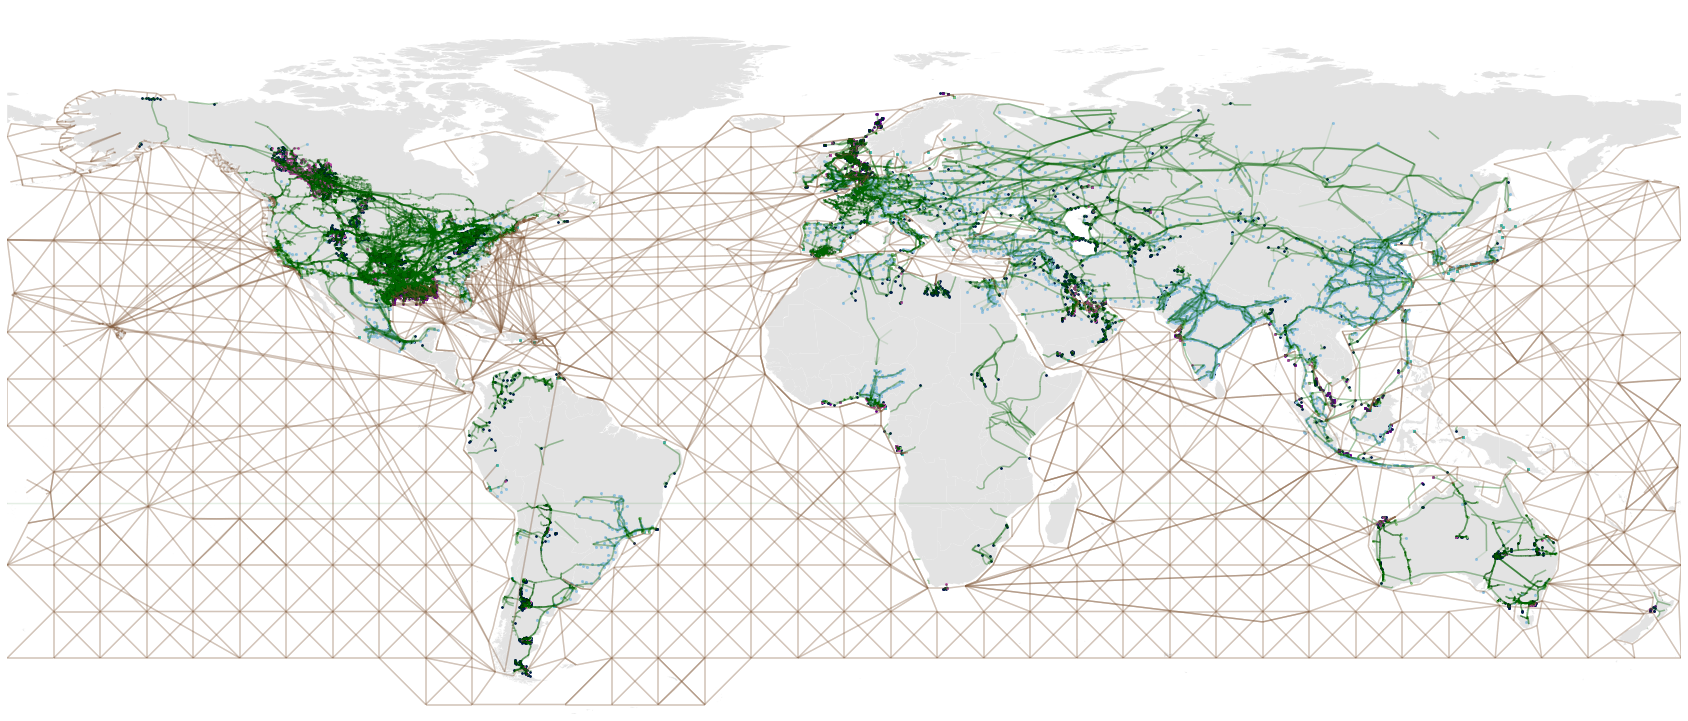

In [44]:
#def vis_connected_network(G):
fig, ax = plt.subplots(1,1,figsize=(30,20))
ne.plot(ax=ax, color='#e3e3e3')

# plot edges: shipping, pieplines
edge_gdf[(edge_gdf['start_type']=='pipe') | (edge_gdf['end_type']=='pipe') ].plot(ax=ax, colors=colors['pipelines'], alpha=0.1)
edge_gdf[(edge_gdf['start_type']=='shipping') | (edge_gdf['end_type']=='shipping') ].plot(ax=ax, colors=colors['shipping'], alpha=0.1)



# plot oil_field, well_pad, lng, city, power

node_gdf[(node_gdf['type']=='lng')].plot(ax=ax, color=colors['lng'], markersize=4)
node_gdf[(node_gdf['type']=='well')].plot(ax=ax, color=colors['well_pads'], markersize=3)
node_gdf[(node_gdf['type']=='oil')].plot(ax=ax, color=colors['oil_fields'], markersize=3)
node_gdf[(node_gdf['type']=='processing')].plot(ax=ax, color=colors['processing_plants'], markersize=3)

node_gdf[(node_gdf['type']=='city') & (node_gdf['D']>0)].plot(ax=ax, color=colors['cities'], markersize=4)
node_gdf[(node_gdf['type']=='power') & (node_gdf['D']>0)].plot(ax=ax, color=colors['power_stations'], markersize=3)


ax.set_xlim([-180,180])
ax.set_ylim([-62,90])
ax.axis('off')
fig.savefig('gas_supplynetwork.png')

plt.show()

### Force-Directed Layout

Out of memory error... loolll
... try again once having run community detection

In [173]:
edge_df['z_inv'] = 1/(edge_df['z']+1)

In [184]:
len(node_df.node.unique())

1024383

In [189]:
# get pos as dict
pos = node_df.drop_duplicates(subset='node')[['node','coordinates']].set_index('node').to_dict('index')

In [190]:
pos = {kk:json.loads(vv['coordinates']) for kk, vv in pos.items()}

In [193]:
z_inv_attr = edge_df[['start','end','z_inv']].set_index(['start','end']).to_dict(orient='index')

In [194]:
nx.set_edge_attributes(gen.G, z_inv_attr)

In [196]:
# pos = nx.spring_layout(gen.G, pos, iterations=1, weight='z_inv')
# big ole 'out of memory' error

### load flows and visualise them

In [45]:
flow_dict = pickle.load(open('./../gas_flow_dict.pkl','rb'))

In [46]:
len(flow_dict.keys())

1500158

In [47]:
flow_dict_reshape = {(i,j): flow_dict[i][j] 
                           for i in flow_dict.keys() 
                           for j in flow_dict[i].keys()}

In [48]:
flow_dict_reshape

{('well_pad_0', 'pipe_node_8.5598434756235824.254184564689314'): 0,
 ('pipe_node_8.5598434756235824.254184564689314',
  'pipe_node_8.5645479642844014.228145858865469'): 0,
 ('pipe_node_8.5598434756235824.254184564689314',
  'pipe_node_8.5729046487769754.272981467921507'): 0,
 ('well_pad_1', 'pipe_node_8.48343442628884.132950375949346'): 0,
 ('pipe_node_8.48343442628884.132950375949346',
  'pipe_node_8.488330269480524.116573061736341'): 0,
 ('pipe_node_8.48343442628884.132950375949346',
  'pipe_node_8.4608897401881474.134912402685865'): 0,
 ('well_pad_100', 'pipe_node_71.2990550055340419.344592084366305'): 0,
 ('pipe_node_71.2990550055340419.344592084366305',
  'pipe_node_71.2877469083372519.33804766282397'): 0,
 ('well_pad_101', 'pipe_node_71.4380670659815419.285623732897836'): 0,
 ('pipe_node_71.4380670659815419.285623732897836',
  'pipe_node_71.521068063640519.342922009262853'): 0,
 ('well_pad_1010', 'pipe_node_101.4699969958527710.080665622848402'): 0,
 ('pipe_node_101.4699969958527

In [49]:
flow_df = pd.DataFrame.from_dict(flow_dict_reshape, orient='index')

In [51]:
flow_df['source']=flow_df.index.str[0]

In [52]:
flow_df = flow_df[~(flow_df.source=='supersource')]

In [53]:
flow_df = flow_df.rename(columns={0:'flow'})

In [54]:
edge_df = edge_df.set_index(['start','end'])

In [55]:
edge_df['flow']=0

In [56]:
edge_df

z  \
start                                        end                                                 
well_pad_0                                   pipe_node_8.5598434756235824.254184564689314    0   
pipe_node_8.5598434756235824.254184564689314 pipe_node_8.5645479642844014.228145858865469    0   
                                             pipe_node_8.5729046487769754.272981467921507    0   
well_pad_1                                   pipe_node_8.48343442628884.132950375949346      0   
pipe_node_8.48343442628884.132950375949346   pipe_node_8.488330269480524.116573061736341     0   
...                                                                                        ...   
shipping_node_34564_B                        shipping_node_34768_B                         683   
                                             shipping_node_33992_B                         287   
shipping_node_33992_B                        shipping_node_34564_B                         287   
                                             shipping_node_34768_B                          28   
shipping_node_125192_B                       shipping_node_125717_B                        401   

                                                                                          start_type  \
start                                        end                                                       
well_pad_0                                   pipe_node_8.5598434756235824.254184564689314       well   
pipe_node_8.5598434756235824.254184564689314 pipe_node_8.5645479642844014.228145858865469       pipe   
                                             pipe_node_8.5729046487769754.272981467921507       pipe   
well_pad_1                                   pipe_node_8.48343442628884.132950375949346         well   
pipe_node_8.48343442628884.132950375949346   pipe_node_8.488330269480524.116573061736341        pipe   
...                                                                                              ...   
shipping_node_34564_B                        shipping_node_34768_B                          shipping   
                                             shipping_node_33992_B                          shipping   
shipping_node_33992_B                        shipping_node_34564_B                          shipping   
                                             shipping_node_34768_B                          shipping   
shipping_node_125192_B                       shipping_node_125717_B                         shipping   

                                                                                           end_type  \
start                                        end                                                      
well_pad_0                                   pipe_node_8.5598434756235824.254184564689314      pipe   
pipe_node_8.5598434756235824.254184564689314 pipe_node_8.5645479642844014.228145858865469      pipe   
                                             pipe_node_8.5729046487769754.272981467921507      pipe   
well_pad_1                                   pipe_node_8.48343442628884.132950375949346        pipe   
pipe_node_8.48343442628884.132950375949346   pipe_node_8.488330269480524.116573061736341       pipe   
...                                                                                             ...   
shipping_node_34564_B                        shipping_node_34768_B                         shipping   
                                             shipping_node_33992_B                         shipping   
shipping_node_33992_B                        shipping_node_34564_B                         shipping   
                                             shipping_node_34768_B                         shipping   
shipping_node_125192_B                       shipping_node_125717_B                        shipping   

                                                                                                                start_coordin

In [57]:
edge_df.loc[flow_df.index, 'flow'] = flow_df['flow']

In [58]:
edge_df.flow.sum()

8485626050

In [59]:
edge_df = edge_df.reset_index()

In [60]:
edge_df = edge_df[edge_df['start']!='supersource']

In [61]:
edge_df

start  \
0                                          well_pad_0   
1        pipe_node_8.5598434756235824.254184564689314   
2        pipe_node_8.5598434756235824.254184564689314   
3                                          well_pad_1   
4          pipe_node_8.48343442628884.132950375949346   
...                                               ...   
3665920                         shipping_node_34564_B   
3665921                         shipping_node_34564_B   
3665922                         shipping_node_33992_B   
3665923                         shipping_node_33992_B   
3665924                        shipping_node_125192_B   

                                                  end    z start_type  \
0        pipe_node_8.5598434756235824.254184564689314    0       well   
1        pipe_node_8.5645479642844014.228145858865469    0       pipe   
2        pipe_node_8.5729046487769754.272981467921507    0       pipe   
3          pipe_node_8.48343442628884.132950375949346    0       well   
4         pipe_node_8.488330269480524.116573061736341    0       pipe   
...                                               ...  ...        ...   
3665920                         shipping_node_34768_B  683   shipping   
3665921                         shipping_node_33992_B  287   shipping   
3665922                         shipping_node_34564_B  287   shipping   
3665923                         shipping_node_34768_B   28   shipping   
3665924                        shipping_node_125717_B  401   shipping   

         end_type                       start_coordinates  \
0            pipe   [8.56379921438752, 4.260457555062633]   
1            pipe  [8.559843475623582, 4.254184564689314]   
2            pipe  [8.559843475623582, 4.254184564689314]   
3            pipe   [8.48256895983809, 4.134045965066479]   
4            pipe    [8.4834344262888, 4.132950375949346]   
...           ...                                     ...   
3665920  shipping             [-70.69139099, 43.13928986]   
3665921  shipping             [-70.69139099, 43.13928986]   
3665922  shipping             [-70.71349335, 43.17829895]   
3665923  shipping             [-70.71349335, 43.17829895]   
3665924  shipping             [-76.14283752, 37.14421082]   

                                end_coordinates  \
0        [8.559843475623582, 4.254184564689314]   
1        [8.564547964284401, 4.228145858865469]   
2        [8.572904648776975, 4.272981467921507]   
3          [8.4834344262888, 4.132950375949346]   
4         [8.48833026948052, 4.116573061736341]   
...                                         ...   
3665920             [-70.55523682, 43.12379837]   
3665921             [-70.71349335, 43.17829895]   
3665922             [-70.69139099, 43.13928986]   
3665923             [-70.55523682, 43.12379837]   
3665924             [-76.10800171, 37.09204102]   

                                                  geometry  flow  
0            LINESTRING (8.56380 4.26046, 8.55984 4.25418)     0  
1            LINESTRING (8.55984 4.25418, 8.56455 4.22815)     0  
2            LINESTRING (8.55984 4.25418, 8.57290 4.27298)     0  
3            LINESTRING (8.48257 4.13405, 8.48343 4.13295)     0  
4            LINESTRING (8.48343 4.13295, 8.48833 4.11657)     0  
...                                                    ...   ...  
3665920  LINESTRING (-70.69139 43.13929, -70.55524 43.1...     0  
3665921  LINESTRING (-70.69139 43.13929, -70.71349 43.1...     0  
3665922  LINESTRING (-70.71349 43.17830, -70.69139 43.1...     0  
3665923  LINESTRING (-70.71349 43.17830, -70.55524 43.1...     0  
3665924  LINESTRING (-76.14284 37.14421, -76.10800 37.0...     0  

[3665925 rows x 9 columns]

### Visualise flow

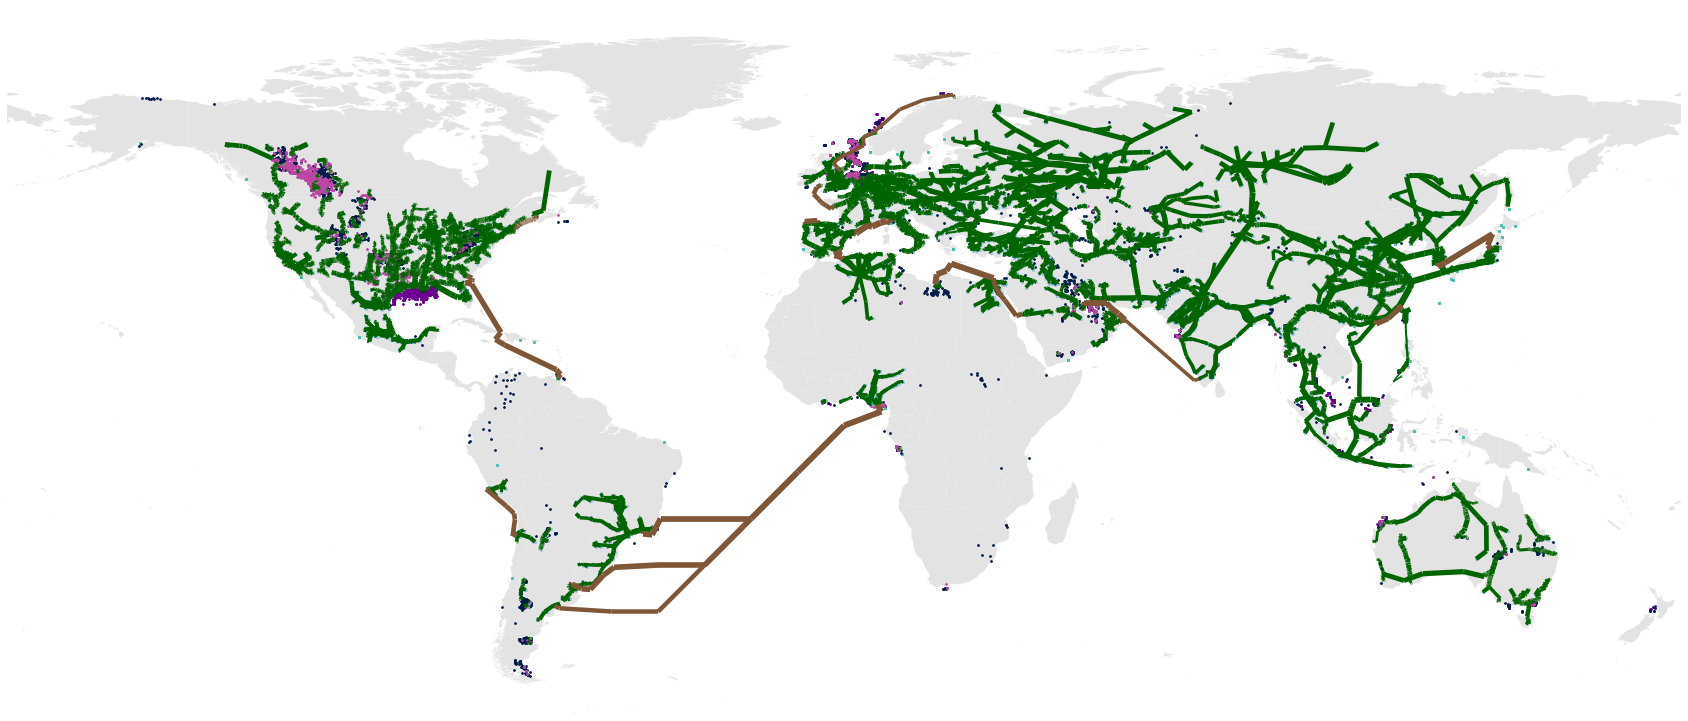

In [62]:
#def vis_connected_network(G):
fig, ax = plt.subplots(1,1,figsize=(30,20))
ne.plot(ax=ax, color='#e3e3e3')
# plot 
# plot oil_field, well_pad, lng, city, power

node_gdf[(node_gdf['type']=='lng')].plot(ax=ax, color=colors['lng'], markersize=4)
node_gdf[(node_gdf['type']=='well')].plot(ax=ax, color=colors['well_pads'], markersize=3)
node_gdf[(node_gdf['type']=='oil')].plot(ax=ax, color=colors['oil_fields'], markersize=3)
node_gdf[(node_gdf['type']=='processing')].plot(ax=ax, color=colors['processing_plants'], markersize=3)

node_gdf[(node_gdf['type']=='city') & (node_gdf['D']>0)].plot(ax=ax, color=colors['cities'], markersize=4)
node_gdf[(node_gdf['type']=='power') & (node_gdf['D']>0)].plot(ax=ax, color=colors['power_stations'], markersize=3)

###

# plot edges
segs = []
line_widths=[]
line_colors = []

for edge in edge_df[(edge_df['flow']>0) & ((edge_gdf['start_type']=='pipe') | (edge_gdf['end_type']=='pipe'))].iterrows():
    segs.append(list(edge[1]['geometry'].coords))
    line_widths.append(np.log10(edge[1]['flow']))
    line_colors.append(colors['pipelines'])
    
for edge in edge_df[(edge_df['flow']>0) & ((edge_gdf['start_type']=='shipping') | (edge_gdf['end_type']=='shipping'))].iterrows():
    segs.append(list(edge[1]['geometry'].coords))
    line_widths.append(np.log10(edge[1]['flow']))
    line_colors.append(colors['shipping'])

line_collection = LineCollection(segs, linewidths=line_widths, colors=line_colors)
    
ax.add_collection(line_collection)
    
ax.set_xlim([-180,180])
ax.set_ylim([-62,90])
ax.axis('off')
fig.savefig('gas_flownetwork.png')

plt.show()

### Check pipelines

In [247]:
pipelines_df = pd.read_csv(all_data_dirs['pipelines-pipelines'])

In [248]:
all_nodes

node_ID                               coordinates
0       city_node_0     [70.3302479906805, 37.76840637200007]
1       city_node_1   [69.91406604103679, 36.969858182710496]
2       city_node_2    [73.55249175449624, 37.13755340600005]
3       city_node_3    [68.66072971923218, 36.93501161119775]
4       city_node_4    [69.80669794370749, 36.44594427548354]
...             ...                                       ...
9840  well_pad_9840  [-90.87808476912353, 28.839718754622925]
9841  well_pad_9841   [-90.82512218382949, 28.87361665367242]
9842  well_pad_9842   [-91.08767461854396, 28.29956690464191]
9843  well_pad_9843  [-91.45741329506177, 28.244583012809247]
9844  well_pad_9844  [-91.73462746919093, 28.407749709815384]

[1841465 rows x 2 columns]

In [249]:
pipelines_df = pipelines_df.merge(all_nodes.drop_duplicates(subset='node_ID'), how='left', left_on='StartNodeId:START_ID(PipelineNode)', right_on='node_ID')

In [251]:
pipelines_df = pipelines_df.merge(all_nodes.drop_duplicates(subset='node_ID'), how='left', left_on='EndNodeId:END_ID(PipelineNode)', right_on='node_ID')

In [270]:
pipelines_df[pipelines_df['coordinates_x'].isna()]

Unnamed: 0              StartNodeId:START_ID(PipelineNode)  \
829770      829770                                               p   
829771      829771                                               p   
829772      829772                                               p   
829773      829773                                               p   
829774      829774                                               p   
...            ...                                             ...   
949057      949057   pipe_node_-95.9655529999953732.16205900040267   
949058      949058  pipe_node_149.0514016985759-25.892028915095715   
949059      949059  pipe_node_-98.6572359994168635.829345999964104   
949062      949062    pipe_node_-102.842322773856247.6827577456162   
949065      949065  pipe_node_-122.5678559994358654.57237999977245   

                         EndNodeId:END_ID(PipelineNode)                :TYPE  \
829770                                                p  PIPELINE_CONNECTION   
829771                                                p  PIPELINE_CONNECTION   
829772                                                p  PIPELINE_CONNECTION   
829773                                                p  PIPELINE_CONNECTION   
829774                                                p  PIPELINE_CONNECTION   
...                                                 ...                  ...   
949057    pipe_node_-95.9660980000065332.16205900040267  PIPELINE_CONNECTION   
949058   pipe_node_149.06160953568602-25.88570218712019  PIPELINE_CONNECTION   
949059    pipe_node_-98.6523850000740635.82432100011652  PIPELINE_CONNECTION   
949062   pipe_node_-102.8786673640261947.62329886400613  PIPELINE_CONNECTION   
949065  pipe_node_-122.5461039998896154.446616000112066  PIPELINE_CONNECTION   

         distance   impedance node_ID_x coordinates_x  \
829770   0.037871    0.001434       NaN           NaN   
829771   0.002931    0.000009       NaN           NaN   
829772   0.700764    0.491070       NaN           NaN   
829773   0.698063    0.487292       NaN           NaN   
829774   0.786355    0.618355       NaN           NaN   
...           ...         ...       ...           ...   
949057   0.666440    0.444142       NaN           NaN   
949058   7.407408   54.869691       NaN           NaN   
949059   2.657773    7.063756       NaN           NaN   
949062  11.690045  136.657143       NaN           NaN   
949065  24.756850  612.901613       NaN           NaN   

                                              node_ID_y  \
829770                                              NaN   
829771                                              NaN   
829772                                              NaN   
829773                                              NaN   
829774                                              NaN   
...                                                 ...   
949057    pipe_node_-95.9660980000065332.16205900040267   
949058                                              NaN   
949059                                              NaN   
949062                                              NaN   
949065  pipe_node_-122.5461039998896154.446616000112066   

                                    coordinates_y  
829770                                        NaN  
829771                                        NaN  
829772                                        NaN  
829773                                        NaN  
829774                                        NaN  
...                                           ...  
949057    [-95.96609800000653, 32.16205900040267]  
949058                                        NaN  
949059                                        NaN  
949062                                        NaN  
949065  [-122.54610399988961, 54.446616000112066]  

[118213 rows x 10 columns]

In [ ]:
pipe_node_-102.842322773856247.6827577456162	

In [273]:
mm = 'pipe_node_-95.965'
len(mm)

17

In [274]:
all_nodes[all_nodes['node_ID'].str[:17]==mm]

node_ID  \
64629  pipe_node_-95.9657560004607929.522648000294154   
64630  pipe_node_-95.9657100005314334.960062999951376   
64631  pipe_node_-95.9656130003360329.592172999715494   
64632   pipe_node_-95.965567999503534.546815999726135   
64633   pipe_node_-95.9655110000103435.46322299995385   
64634   pipe_node_-95.9655066406955727.88224352008478   
64635  pipe_node_-95.9651100005625928.902147000184748   

                                    coordinates  
64629  [-95.96575600046079, 29.522648000294154]  
64630  [-95.96571000053143, 34.960062999951376]  
64631  [-95.96561300033603, 29.592172999715494]  
64632   [-95.9655679995035, 34.546815999726135]  
64633   [-95.96551100001034, 35.46322299995385]  
64634   [-95.96550664069557, 27.88224352008478]  
64635  [-95.96511000056259, 28.902147000184748]

In [214]:
dd = {'meow':{'a':2,'b':5},'woof':{'b':7,'d':6}}

In [215]:
a = pd.DataFrame.from_dict(dd, orient='index')

In [216]:
a=a.unstack()

In [218]:
a[a>0].reset_index()

level_0 level_1    0
0       a    meow  2.0
1       b    meow  5.0
2       b    woof  7.0
3       d    woof  6.0

In [226]:
for ii_k, (kk, vv) in enumerate(flow_dict.items()):
    if ii_k%2500==0:
        print (ii_k)
    for kk2, flowval in vv.items():
        if flowval>0:
            edge_df.loc[(kk,kk2),'flow'] = flowval

0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
112500
115000
117500
120000
122500
125000
127500
130000
132500
135000
137500
140000
142500
145000
147500
150000
152500
155000
157500
160000
162500
165000
167500
170000
172500
175000
177500
180000
182500
185000
187500
190000
192500
195000
197500
200000
202500
205000
207500
210000
212500
215000
217500
220000
222500
225000
227500
230000
232500
235000
237500
240000
242500
245000
247500
250000
252500
255000
257500
260000
262500
265000
267500
270000
272500
275000
277500
280000
282500
285000
287500
290000
292500
295000
297500
300000
302500
305000
307500
310000
312500
315000
317500
320000
322500
325000
327500
330000
332500
335000
337500
340000
342500
345000
347500
350000
352500
355000
357500
360000
362500
365000
367500
370000
3725

KeyboardInterrupt: 